In [1]:
# This chapter discussed two classification algorithms: naive bayesian classification and bayesian classification with covariance.
#
# The basic methodology is to find out the distribution of the measurements M for each group A.
# Then based on the measurements M' we made about a new sample, we use it to determine the group 
# it belongs to by performing bayesian updates based on the likelihood of M' for each group.
#
# In the book, the sample data's mean and std are calculated for each measurement, which determine the
# normal distribution for each measurement. Finally, the normal distribution is used to calculate the
# likelihoods.
#
# The not-so-naive covariance method talks about the potential correlation between the measurements.
# For example, Penguins with larger beaks tend to be taller because they tend to have larger body size.
# So if we take the covariance of the measurements into account, we can get a better likelihood estimation.
#

In [2]:
# The data was stolen from https://gist.github.com/ryanorsinger/0e223fb35472c40d449cec4c0737008b
!wget -O data/penguins.csv https://gist.githubusercontent.com/ryanorsinger/0e223fb35472c40d449cec4c0737008b/raw

--2024-01-11 11:02:14--  https://gist.githubusercontent.com/ryanorsinger/0e223fb35472c40d449cec4c0737008b/raw
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15240 (15K) [text/plain]
Saving to: ‘data/penguins.csv’

data/penguins.csv   100%[===================>]  14.88K  --.-KB/s    in 0s      

2024-01-11 11:02:14 (35.2 MB/s) - ‘data/penguins.csv’ saved [15240/15240]



In [3]:
import pandas as pd
from empiricaldist import Cdf
from utils import Pmf
from scipy.stats import norm
import numpy as np

df = pd.read_csv('data/penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


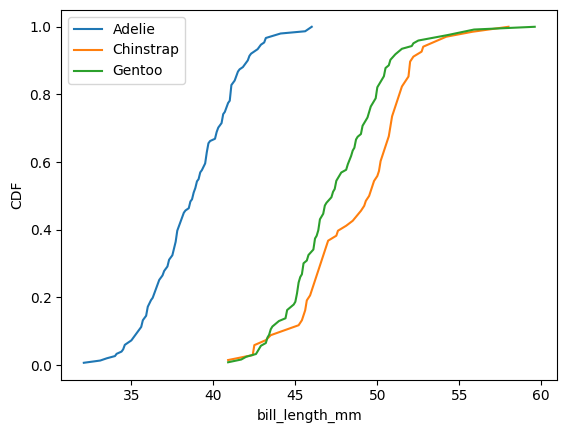

In [5]:
# with this function we make cdf for a chosen measurment. this allows us
# to compare the distribution of measurement for each species.
def make_cdf_map(df, colname, by='species'):
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

def plot_measurment_cdf(df, colname, by='species'):
    cdf_map = make_cdf_map(df, colname, by)
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, legend=True, xlabel=colname, ylabel="CDF")

plot_measurment_cdf(df, "bill_length_mm")

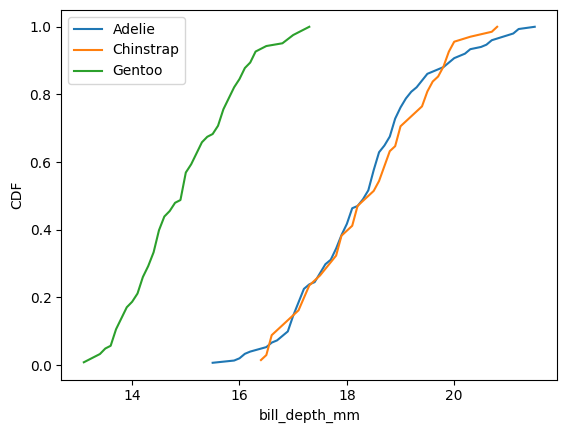

In [7]:
plot_measurment_cdf(df, "bill_depth_mm")

In [11]:
# now let's make a normal dsitribution for each measurements of each species
def make_norm_map(df, colnames, by='species'):
    norm_map = {}
    for colname in colnames:
        norm_map[colname] = {}
        cdf_map = make_cdf_map(df, colname, by)
        for species, cdf in cdf_map.items():
            print(f'{colname} {species}: ', (cdf.mean(), cdf.std()))
            norm_map[colname][species] = norm(cdf.mean(), cdf.std())
    return norm_map

norm_map = make_norm_map(df, ['bill_length_mm', 'bill_depth_mm'])

bill_length_mm Adelie:  (38.79139072847682, 2.6545709771066246)
bill_length_mm Chinstrap:  (48.83382352941177, 3.31461160417102)
bill_length_mm Gentoo:  (47.5048780487805, 3.069303929418552)
bill_depth_mm Adelie:  (18.34635761589404, 1.2126144287882998)
bill_depth_mm Chinstrap:  (18.42058823529412, 1.1270156874957824)
bill_depth_mm Gentoo:  (14.982113821138213, 0.9772229210631793)


In [49]:
def classify(norm_map, measurements, classes='auto'):
    if classes == 'auto':
        classes = list(list(norm_map.values())[0].keys())
        
    prior = Pmf(1, classes)
    for colname, value in measurements.items():
        likelihood = [norm_map[colname][c].pdf(value) for c in classes]
        prior *= likelihood
    prior.normalize()
    return prior

example_classification = classify(norm_map, {'bill_length_mm': 40, 'bill_depth_mm': 18})
print(example_classification.idxmax())
example_classification

Adelie


,probs
Adelie,0.973552
Chinstrap,0.025932
Gentoo,0.000516


In [55]:
# Now we try to evaluate how good our model performs on the original dataset.
def evaluate(df, norm_map, measurement_fields='auto', class_field='species'):
    if measurement_fields == 'auto':
        measurement_fields = norm_map.keys()
        
    n_valid = 0
    n_correct = 0
    for _, row in df.iterrows():
        measurements = dict(row[measurement_fields])
        if any(np.isnan(v) for v in measurements.values()):
            continue
        n_valid += 1
        true_class = str(row[class_field])
        inferred_class = classify(norm_map, measurements)
        if true_class == inferred_class.idxmax():
            n_correct += 1
    return (n_valid, n_correct, n_correct*1.0/n_valid)

evaluate(df, norm_map)

(342, 321, 0.9385964912280702)

In [57]:
# let's try with more measurement dimensions
norm_map2 = make_norm_map(df, ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])
evaluate(df, norm_map2)

bill_length_mm Adelie:  (38.79139072847682, 2.6545709771066246)
bill_length_mm Chinstrap:  (48.83382352941177, 3.31461160417102)
bill_length_mm Gentoo:  (47.5048780487805, 3.069303929418552)
bill_depth_mm Adelie:  (18.34635761589404, 1.2126144287882998)
bill_depth_mm Chinstrap:  (18.42058823529412, 1.1270156874957824)
bill_depth_mm Gentoo:  (14.982113821138213, 0.9772229210631793)
flipper_length_mm Adelie:  (189.95364238410596, 6.517767614763347)
flipper_length_mm Chinstrap:  (195.8235294117647, 7.079259633253841)
flipper_length_mm Gentoo:  (217.18699186991867, 6.458560328762061)
body_mass_g Adelie:  (3700.6622516556286, 457.04517271224495)
body_mass_g Chinstrap:  (3733.088235294118, 381.49862135646805)
body_mass_g Gentoo:  (5076.016260162602, 502.0628014961636)


(342, 331, 0.9678362573099415)

In [86]:
# Now let's play with covariance.
from scipy.stats import multivariate_normal

def make_multinorm_map(df, colnames, by='species'):
    norm_map = {}
    grouped = df.groupby(by)
    for species, group in grouped:
        features = group[colnames]
        norm_map[species] = multivariate_normal(features.mean(), features.cov())
    return norm_map

multinorm_map = make_multinorm_map(df, ['bill_length_mm', 'bill_depth_mm'])

In [87]:
# now let's evaluate the performance

# NOTE: argument 'measurements' is a list of floats representing the measurements made
# it must be taken in the same order as the second argument of make_multinorm_map.
def classify_multinorm(multinorm_map, measurements, classes='auto'):
    if classes == 'auto':
        classes = multinorm_map.keys()

    prior = Pmf(1, classes)
    likelihoods = []
    for c in classes:
        likelihoods.append(multinorm_map[c].pdf(measurements))
    prior *= likelihoods
    prior.normalize()
    return prior
    
def evaluate_multinorm(df, multinorm_map, measurement_fields, class_field='species'):
    n_valid = 0
    n_correct = 0
    for _, row in df.iterrows():
        measurements = list(row[measurement_fields])
        if any(np.isnan(v) for v in measurements):
            continue
        n_valid += 1
        true_class = str(row[class_field])
        inferred_class = classify_multinorm(multinorm_map, measurements)
        if true_class == inferred_class.idxmax():
            n_correct += 1
    return (n_valid, n_correct, n_correct*1.0/n_valid)
    
evaluate_multinorm(df, multinorm_map, ['bill_length_mm', 'bill_depth_mm'])

(342, 333, 0.9736842105263158)

In [88]:
# this time we got 333/342 right, better than previous attempt 321/342

In [89]:
# Exercise 12-1: implement a classifier using all four features.
#
# I have already done that previously for the normal predictor. I haven't done it for
# the multinorm version yet so here I'll try it.

multinorm_map2 = make_multinorm_map(df, ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])
evaluate_multinorm(df, multinorm_map2, ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])

(342, 339, 0.9912280701754386)

In [ ]:
# 339/342, 99% correct. It's a lot better than previous version.

In [93]:
# Exercise 12-2: use a bayesian classifier to classify the penguins by sex.
# Answer: which features are most useful? What's the accuracy?

# Attempt 1: single-feature classifier with the goal of finding the most useful feature
all_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
norm_maps_by_sex = {f: make_norm_map(df, [f], by='sex') for f in all_features}
print('--------------------')

for f, norm_map in norm_maps_by_sex.items():
    print(f'{f}: ', evaluate(df, norm_maps_by_sex[f], class_field='sex'))

bill_length_mm female:  (42.0969696969697, 4.888594322873109)
bill_length_mm male:  (45.85476190476191, 5.35089900684043)
bill_depth_mm female:  (16.42545454545455, 1.790231220734199)
bill_depth_mm male:  (17.891071428571426, 1.857796645451364)
flipper_length_mm female:  (197.36363636363637, 12.462837319390268)
flipper_length_mm male:  (204.5059523809524, 14.504513675063821)
body_mass_g female:  (3862.2727272727275, 664.1502783907429)
body_mass_g male:  (4545.684523809525, 785.2812518597349)
--------------------
bill_length_mm:  (342, 193, 0.564327485380117)
bill_depth_mm:  (342, 205, 0.5994152046783626)
flipper_length_mm:  (342, 180, 0.5263157894736842)
body_mass_g:  (342, 199, 0.5818713450292398)


In [94]:
# Unfortunately, none of them perform well enough.
# Attempt 2: let's try combining all features.

norm_maps_by_sex_2 = make_norm_map(df, all_features, by='sex')
evaluate(df, norm_maps_by_sex_2, class_field='sex')

bill_length_mm female:  (42.0969696969697, 4.888594322873109)
bill_length_mm male:  (45.85476190476191, 5.35089900684043)
bill_depth_mm female:  (16.42545454545455, 1.790231220734199)
bill_depth_mm male:  (17.891071428571426, 1.857796645451364)
flipper_length_mm female:  (197.36363636363637, 12.462837319390268)
flipper_length_mm male:  (204.5059523809524, 14.504513675063821)
body_mass_g female:  (3862.2727272727275, 664.1502783907429)
body_mass_g male:  (4545.684523809525, 785.2812518597349)


(342, 246, 0.7192982456140351)

In [96]:
# An improvement, but 72% isn't great either.
# Attempt 3: let us try the multivariate model.
norm_maps_by_sex_2 = make_multinorm_map(df, all_features, by='sex')
evaluate_multinorm(df, norm_maps_by_sex_2, all_features, class_field='sex')

(342, 302, 0.8830409356725146)

In [108]:
# A lot better. But it's still not good enough. How about we use a two-stage predictor:
# first determine the species using the measurements, then under each species we use
# the measurement to determine the sex?
# Attempt 4: speciated multi_norm
def make_speciated_sex_model(df, features):
    model = {}
    for species, group in df.groupby('species'):
        model[species] = {}
        measurements = group[features]
        mean = measurements.mean()
        cov = measurements.cov()
        model[species]['model'] = multivariate_normal(mean, cov)

        # then for each sex
        for sex, group in group.groupby('sex'):
            measurements = group[features]
            mean = measurements.mean()
            cov = measurements.cov()
            model[species][sex] = multivariate_normal(mean, cov)
    return model

def classify_speciated_sex(model, measurements):
    species_classes = model.keys()
    prior_species = Pmf(1, species_classes)
    likelihood_species = [model[s]['model'].pdf(measurements) for s in species_classes]
    species = (prior_species * likelihood_species).idxmax()

    sex_classes = [k for k in model[species].keys() if k != 'model']
    prior_sex = Pmf(1, sex_classes)
    likelihood_sex = [model[species][s].pdf(measurements) for s in sex_classes]
    sex_posterior = prior_sex * likelihood_sex
    sex_posterior.normalize()
    return sex_posterior

def evaluate_speciated_sex(df, model, features):
    n_valid = 0
    n_correct = 0
    for _, row in df.iterrows():
        measurements = list(row[features])
        if any(np.isnan(v) for v in measurements):
            continue
        n_valid += 1
        true_class = str(row['sex'])
        inferred_class = classify_speciated_sex(model, measurements)
        if true_class == inferred_class.idxmax():
            n_correct += 1
    return (n_valid, n_correct, n_correct*1.0/n_valid)

norm_maps_by_sex_3 = make_speciated_sex_model(df, all_features)
evaluate_speciated_sex(df, norm_maps_by_sex_3, all_features)

(342, 309, 0.9035087719298246)